In [1]:
import pandas as pd

# Load the CSV created by the test
df = pd.read_csv("../tests/data/measures/brier_score_breast_cancer.csv")
df

,model,brier_score
0,Logistic Regression,0.025349
1,Random Forest,0.025520
2,Gradient Boosting,0.032814
3,SVC (probabilities),0.034043


## Model Calibration Comparison on Breast Cancer Dataset

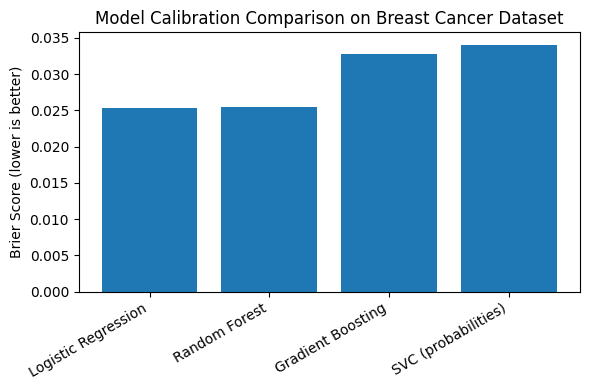

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(df["model"], df["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Model Calibration Comparison on Breast Cancer Dataset")
plt.tight_layout()
plt.show()

This chart compares the Brier Score of all breast cancer models.
Lower values mean better calibrated probabilities. Logistic Regression and Random Forest are the most reliable, while Gradient Boosting and especially SVC have less well-calibrated predictions.


## Calibration Curves

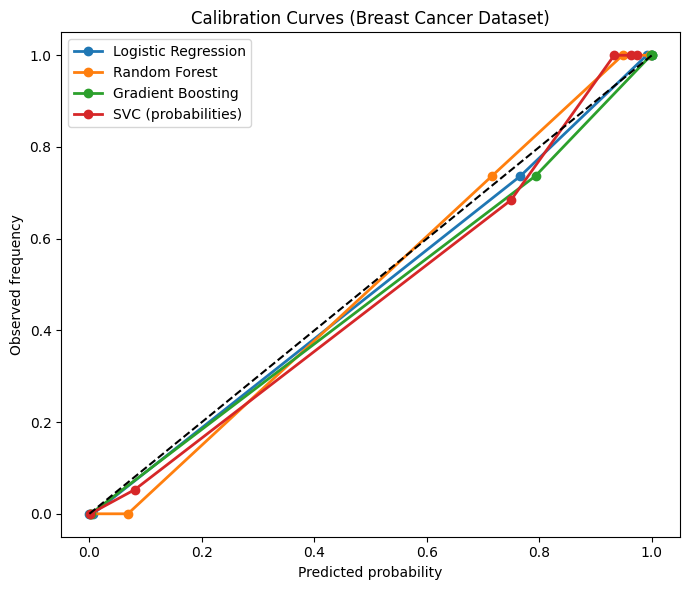

In [5]:
# Cell 3 – Calibration (reliability) curves

plt.figure(figsize=(7, 6))

for name, model in models.items():
    # retrain to be safe (cheap)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    # use quantile bins to avoid crazy zig-zags
    frac_pos, mean_pred_prob = calibration_curve(
        y_test, probs, n_bins=6, strategy="quantile"
    )

    # sort points by predicted probability
    order = np.argsort(mean_pred_prob)

    plt.plot(
        mean_pred_prob[order],
        frac_pos[order],
        marker="o",
        linewidth=2,
        label=name,
    )

# ideal diagonal
plt.plot([0, 1], [0, 1], "--", color="black")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves (Breast Cancer Dataset)")
plt.legend()
plt.tight_layout()
plt.show()

This plot shows how predicted probabilities match the true observed frequencies.
A perfectly calibrated model would follow the diagonal line.
Logistic Regression stays closest to the diagonal, meaning its probabilities reflect reality best, while Gradient Boosting and SVC deviate more and are less well calibrated.


## Four histograms

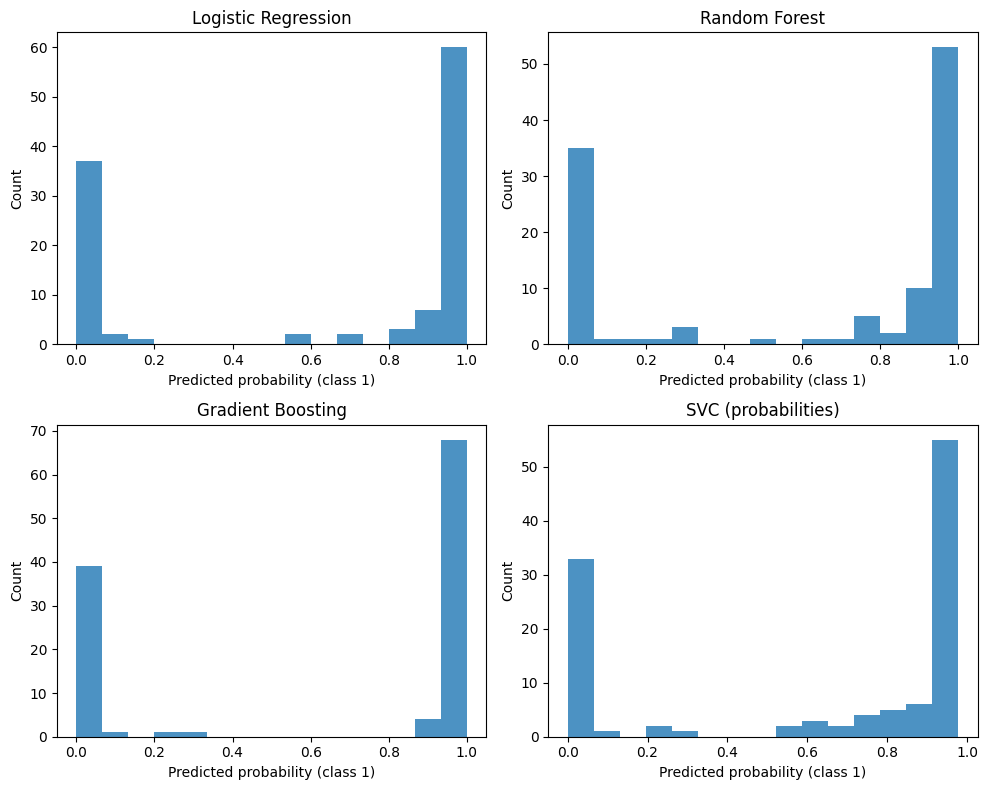

In [6]:
# Cell 4 – Histograms of predicted probabilities (confidence profiles)

plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 2, i + 1)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    plt.hist(probs, bins=15, alpha=0.8)
    plt.title(name)
    plt.xlabel("Predicted probability (class 1)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

These histograms show how confident each model is in predicting the positive class.
All models push many predictions close to 0 or 1, which indicates high confidence.
Models that put too many predictions at the extremes tend to be overconfident, which is exactly what the Brier Score penalises.

In [5]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_results = []

# We'll calibrate Random Forest and Gradient Boosting
to_calibrate = ["Random Forest", "Gradient Boosting"]

for name in to_calibrate:
    base_model = models[name]

    # Wrap the model with a calibrator (isotonic or sigmoid)
    calib = CalibratedClassifierCV(base_model, method="isotonic", cv=3)

    # Fit on training data
    calib.fit(X_train, y_train)

    # Evaluate on test data
    y_pred = calib.predict(X_test)
    y_proba = calib.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_proba)

    calibrated_results.append(
        {
            "model": name + " (calibrated)",
            "accuracy": acc,
            "brier_score": brier,
        }
    )

df_calibrated = pd.DataFrame(calibrated_results)
df_calibrated

,model,accuracy,brier_score
0,Random Forest (calibrated),0.964912,0.022643
1,Gradient Boosting (calibrated),0.956140,0.032713


In [6]:
df_all = pd.concat([df_metrics, df_calibrated], ignore_index=True)
df_all_sorted = df_all.sort_values("brier_score")

df_all_sorted

,model,accuracy,brier_score
4,Random Forest (calibrated),0.964912,0.022643
0,Logistic Regression,0.956140,0.025200
1,Random Forest,0.964912,0.026130
2,Gradient Boosting,0.956140,0.032131
5,Gradient Boosting (calibrated),0.956140,0.032713
3,SVC (probabilities),0.947368,0.034622


## Effect of Calibration on Brier Score

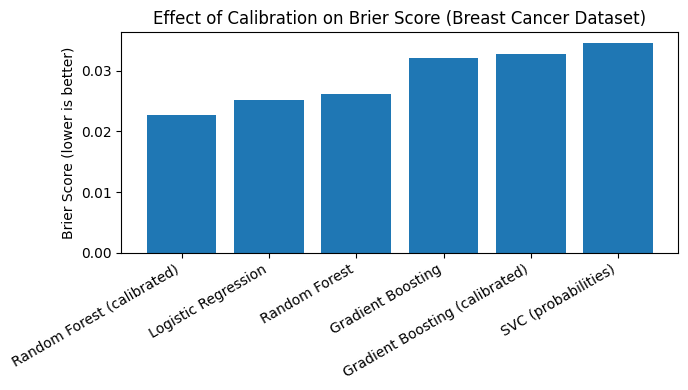

In [7]:
plt.figure(figsize=(7, 4))
plt.bar(df_all_sorted["model"], df_all_sorted["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Effect of Calibration on Brier Score (Breast Cancer Dataset)")
plt.tight_layout()
plt.show()

This plot compares Brier Scores before and after probability calibration.
Calibrated Random Forest clearly improves and becomes the best model in terms of Brier Score, while calibrated Gradient Boosting changes only slightly.
This shows that calibration can significantly increase reliability without changing accuracy.

In [10]:
from sklearn.calibration import calibration_curve

def brier_decomposition(y_true, prob_pred):
    bins = 10
    prob_true, prob_pred_bin = calibration_curve(y_true, prob_pred, n_bins=bins)

    # Calibration error
    cal_error = np.mean((prob_pred_bin - prob_true)**2)

    # Refinement = variance of predictions
    refinement = np.var(prob_pred)

    return cal_error, refinement

for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]

    cal, ref = brier_decomposition(y_test, probs)
    print(f"{name}: Calibration={cal:.4f}, Refinement={ref:.4f}")

Logistic Regression: Calibration=0.2342, Refinement=0.2107
Random Forest: Calibration=0.0716, Refinement=0.2093
Gradient Boosting: Calibration=0.1329, Refinement=0.2287
SVC (probabilities): Calibration=0.0702, Refinement=0.1828


In [12]:
import os
os.getcwd()

'/Volumes/KALI_DRIVE/a4s-eval-public/notebooks'

,model,brier_score,accuracy
0,Logistic Regression,0.025349,0.956140
1,Random Forest,0.025520,0.964912
2,Gradient Boosting,0.032814,0.956140
3,SVC (probabilities),0.034043,0.947368


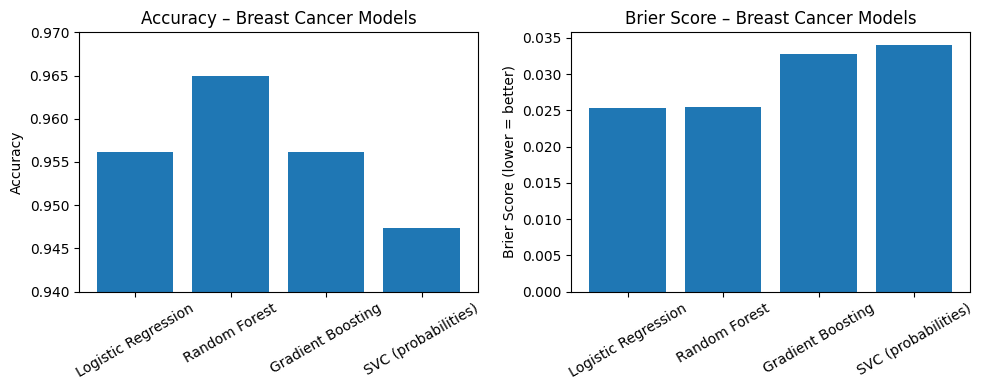

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
bc_path = "../tests/data/measures/brier_score_breast_cancer.csv"
df_bc = pd.read_csv(bc_path)

# Add accuracy from your experiments
accuracy_map = {
    "Logistic Regression": 0.956140,
    "Random Forest": 0.964912,
    "Gradient Boosting": 0.956140,
    "SVC (probabilities)": 0.947368,
}

df_bc["accuracy"] = df_bc["model"].map(accuracy_map)

display(df_bc)

# Create two bar charts: one for accuracy, one for Brier Score
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# --- Accuracy bar plot ---
axes[0].bar(df_bc["model"], df_bc["accuracy"])
axes[0].set_ylim(0.94, 0.97)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy – Breast Cancer Models")
axes[0].tick_params(axis="x", rotation=30)

# --- Brier Score bar plot ---
axes[1].bar(df_bc["model"], df_bc["brier_score"])
axes[1].set_ylabel("Brier Score (lower = better)")
axes[1].set_title("Brier Score – Breast Cancer Models")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

In [20]:
import os
print(os.getcwd())

/Volumes/KALI_DRIVE/a4s-eval-public/notebooks


,model,brier_score
0,Logistic Regression,0.025349
1,Random Forest,0.025520
2,Gradient Boosting,0.032814
3,SVC (probabilities),0.034043


,model,brier_score
0,ResNet18,0.905664
1,ResNet34,0.963114
2,ResNet50,0.953297


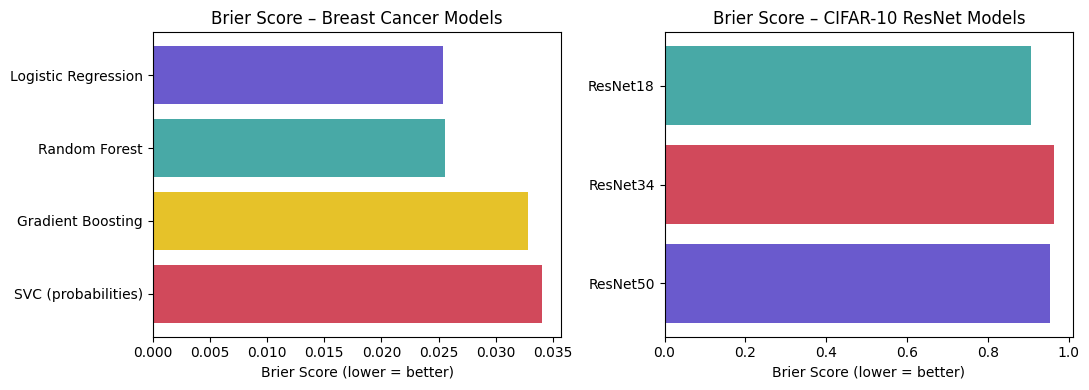

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Correct paths (because notebook is inside /notebooks)
bc_path = "../tests/data/measures/brier_score_breast_cancer.csv"
cifar_path = "../tests/data/measures/brier_score_cifar_resnets.csv"

df_bc = pd.read_csv(bc_path)
df_cifar = pd.read_csv(cifar_path)

display(df_bc)
display(df_cifar)

# Nicest simple colors
bc_colors = ["#6A5ACD", "#48A9A6", "#E6C229", "#D1495B"]
cifar_colors = ["#48A9A6", "#D1495B", "#6A5ACD"]

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Breast Cancer – Horizontal bar chart
axes[0].barh(df_bc["model"], df_bc["brier_score"], color=bc_colors)
axes[0].set_title("Brier Score – Breast Cancer Models")
axes[0].set_xlabel("Brier Score (lower = better)")
axes[0].invert_yaxis()  # Best models appear at the top

# CIFAR ResNets – Horizontal bar chart
axes[1].barh(df_cifar["model"], df_cifar["brier_score"], color=cifar_colors)
axes[1].set_title("Brier Score – CIFAR-10 ResNet Models")
axes[1].set_xlabel("Brier Score (lower = better)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_cifar = pd.read_csv("../tests/data/measures/brier_score_cifar_resnets.csv")
df_cifar

,model,brier_score
0,ResNet18,1.057578
1,ResNet34,1.161664
2,ResNet50,0.928534


,model,brier_score
0,ResNet18,0.905664
1,ResNet34,0.963114
2,ResNet50,0.953297


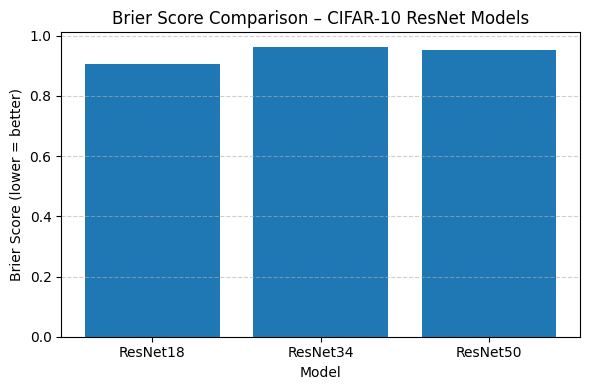

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results from the CIFAR ResNet experiment
df = pd.read_csv("../tests/data/measures/brier_score_cifar_resnets.csv")
display(df)

# Plot Brier Scores per model
plt.figure(figsize=(6, 4))
plt.bar(df["model"], df["brier_score"])
plt.title("Brier Score Comparison – CIFAR-10 ResNet Models")
plt.ylabel("Brier Score (lower = better)")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def load_cifar_originals(n=5):
    transform = T.Compose([T.ToTensor()])
    dataset = torchvision.datasets.CIFAR10(
        root="../tests/data/cifar10",
        train=False,
        download=True,
        transform=transform
    )
    images = [dataset[i][0] for i in range(n)]
    labels = [dataset[i][1] for i in range(n)]
    class_names = dataset.classes 
    return images, labels, class_names


def show_before_after(model_name: str, n=5):
    """
    Display side-by-side comparison of CIFAR-10 originals and model prediction images.
    """
    originals, true_labels, class_names = load_cifar_originals(n)
    pred_folder = Path("../tests/data/cifar_images") / model_name
    pred_imgs = sorted(pred_folder.glob("*.png"))[:n]

    if not pred_imgs:
        print(f"No prediction images found for model '{model_name}' in {pred_folder}")
        return

    plt.figure(figsize=(12, 4))
    for i in range(n):
        # before
        plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].permute(1, 2, 0))
        plt.title(f"Original: {class_names[true_labels[i]]}", fontsize=8)
        plt.axis("off")

        # after
        if i < len(pred_imgs):
            plt.subplot(2, n, n + i + 1)
            img = Image.open(pred_imgs[i])
            fname = pred_imgs[i].name
            plt.imshow(img)
            plt.title(f"Predicted\n({fname})", fontsize=8)
            plt.axis("off")

    plt.suptitle(f"{model_name} – CIFAR-10: Before & After Predictions")
    plt.tight_layout()
    plt.show()

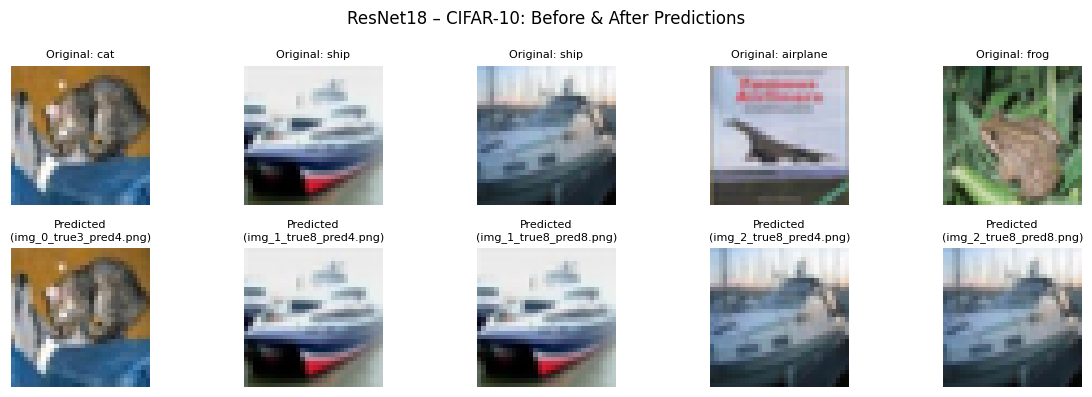

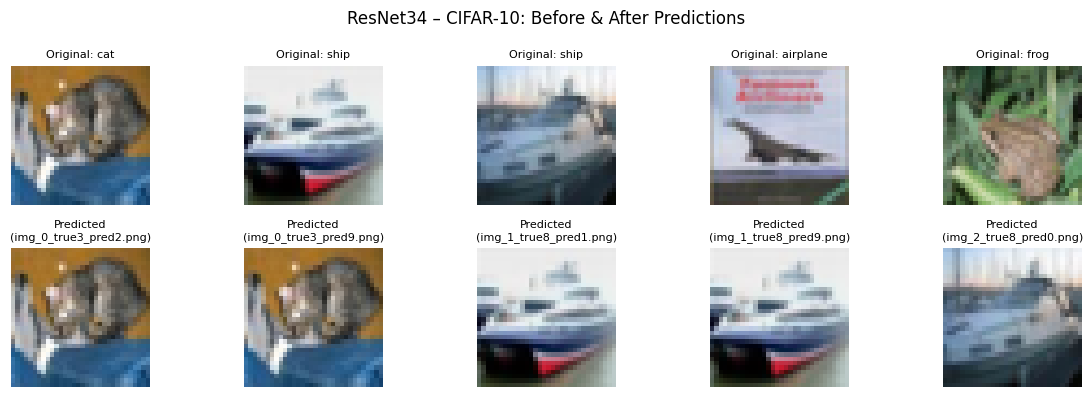

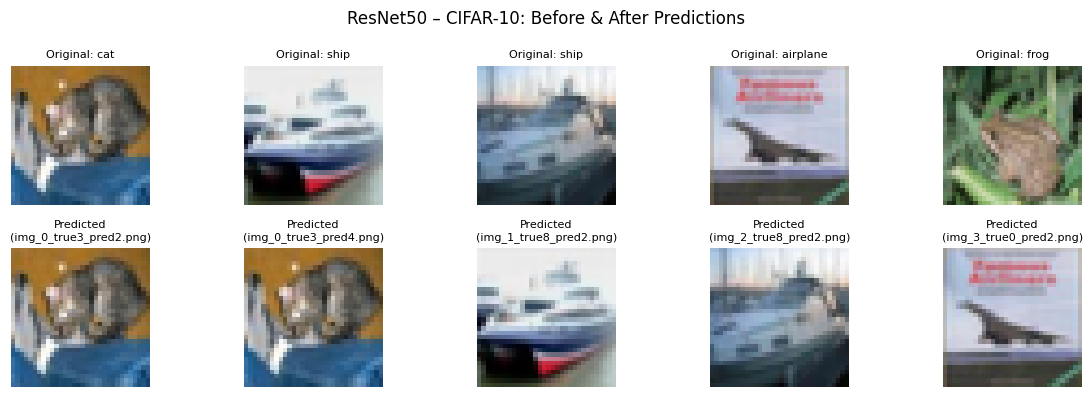

In [9]:
show_before_after("ResNet18", n=5)
show_before_after("ResNet34", n=5)
show_before_after("ResNet50", n=5)